Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


Load and Inspect Dataset

In [ ]:
# Load the dataset
data = pd.read_csv('/content/Google_Stock_Price_Train.csv')

# Select relevant columns
features = ['Open', 'High', 'Low', 'Close', 'Volume']
data = data[features]


Normalize the Data

In [ ]:
# Convert columns to numeric, handling commas
for column in features:
    # Check if the column is not numeric
    if not pd.api.types.is_numeric_dtype(data[column]):
        # If not numeric, apply string operations
        data[column] = pd.to_numeric(data[column].str.replace(',', ''), errors='coerce')
    else:
        # If numeric, do nothing
        pass

# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Convert to DataFrame for easier handling
scaled_data = pd.DataFrame(scaled_data, columns=features)
print(scaled_data.head())

       Open      High       Low     Close    Volume
0  0.085814  0.096401  0.090449  0.237573  0.295258
1  0.097012  0.098344  0.098235  0.241514  0.229936
2  0.094334  0.092517  0.094086  0.228781  0.263612
3  0.091562  0.088819  0.088006  0.216419  0.216179
4  0.079842  0.076718  0.061070  0.178548  0.467797


Create Training and Validation

In [ ]:
# Define the sequence length (N = 30) and target days (M = 1)
N = 30
M = 1

# Prepare sequences
X, y = [], []
for i in range(N, len(scaled_data) - M + 1):
    X.append(scaled_data.iloc[i-N:i].values)  # Past N days
    y.append(scaled_data.iloc[i+M-1:i+M]['Close'].values)  # Target M days

X = np.array(X)
y = np.array(y)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
print(f"Training samples: {X_train.shape}, Validation samples: {X_val.shape}")


Training samples: (982, 30, 5), Validation samples: (246, 30, 5)


Build the RNN Model

In [ ]:
model = Sequential()

# Add LSTM layers with Dropout
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Add Dense layer
model.add(Dense(units=1))  # Predicting one value (next day's close price)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Train the Model

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0442 - val_loss: 0.0028
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0095 - val_loss: 0.0020
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0094 - val_loss: 0.0031
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0057 - val_loss: 5.7330e-04
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0045 - val_loss: 6.5738e-04
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0063 - val_loss: 6.2483e-04
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0055 - val_loss: 5.0023e-04
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0043 - val_loss: 0.0094
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0049 - val_loss: 7.4952e-04
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0040 - val_loss: 0.0028
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0047 - val_loss: 0.0018
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 2

Evaluate the Model

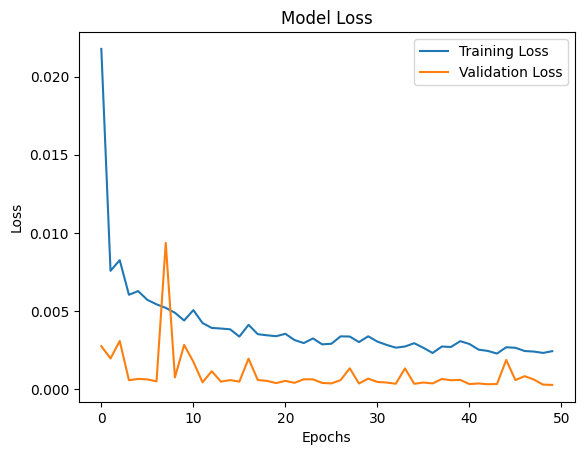

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model
y_val_pred = model.predict(X_val)
y_val_pred_original = scaler.inverse_transform(np.hstack((np.zeros((len(y_val_pred), 4)), y_val_pred)))[:, 4]
y_val_original = scaler.inverse_transform(np.hstack((np.zeros((len(y_val), 4)), y_val.reshape(-1, 1))))[:, 4]


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


Performance Metrics

In [ ]:
# Performance Metrics
mse = mean_squared_error(y_val_original, y_val_pred_original)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val_original, y_val_pred_original)

print(f"Validation Set Performance:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Validation Set Performance:
Mean Squared Error (MSE): 169358321160.0606
Root Mean Squared Error (RMSE): 411531.6770
Mean Absolute Error (MAE): 306677.2493


Visualize results

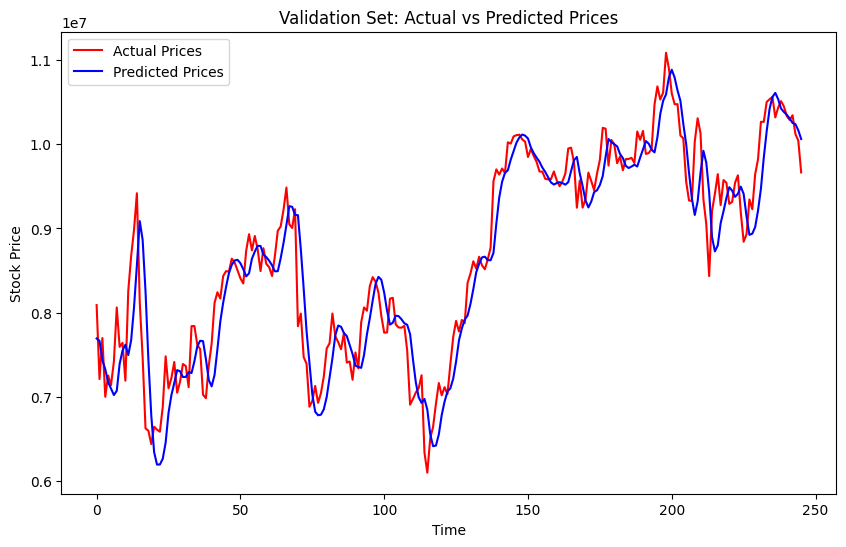

In [ ]:
# Visualize results
plt.figure(figsize=(10, 6))
plt.plot(y_val_original, color='red', label='Actual Prices')
plt.plot(y_val_pred_original, color='blue', label='Predicted Prices')
plt.title('Validation Set: Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
